In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix

Using TensorFlow backend.
/home/omid/.conda/envs/iot_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Main configs

In [23]:
loadFromMerged=True
loadFromIndexes= True
Mapper='F'
IgnoreEmpty= False
FoldID ="1"
Epoch_count=100
Batch_size=500

# Load the data the old way


In [4]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [5]:
#  mapps the input records to a integer array for the input
def mapping_x( inp ):
    return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1) for x in inp ])

In [22]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_device_service(inp):
    return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_full(inp):
    return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )


In [21]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S'):
    cleans = [] 
    cleans = sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] )
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    ret_x  = [ mapping_x(x) for x in ret_x ] 
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y ]
    return ret_x, ret_y

In [24]:
x= []
y= []

x_test = {}
y_test = {}

x_train = {}
y_train = {}



if loadFromMerged:
    with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
        x_data = json.load(f)

    if len( y_data ) != len(x_data) :
        print( pick )
    #     continue

    with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
        index_info = json.load(f)
    
    
    for i in index_info[FoldID]["test"]:
        x_test[str(i)]=( x_data[str(i)] )
        y_test[str(i)]=(  y_data[str(i)] )
    
    for i in index_info[FoldID]["train"]:
        x_train[str(i)]=(  x_data[str(i)] )
        y_train[str(i)]=(  y_data[str(i)] )
    
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
    
    
    x_test,y_test= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
    x_train,y_train= clean_data( x_train, y_train, IgnoreEmpty , Mapping=Mapper )

#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in glob.glob( '../files/train/hub_segments/*.json' ):
        fname  = os.path.basename(pick)
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True )

        x.extend( t_x)
        y.extend(t_y)

x= np.array( x )
y= np.array(y)

len(x_train), len(y_test)

(50358, 12590)

In [25]:
sorted(list(np.unique(  np.concatenate( y_train  ))))

['Centralite_Micro_Door_Sensor & activity & hubDisconnected',
 'Centralite_Micro_Door_Sensor & activity & offline',
 'Centralite_Micro_Door_Sensor & activity & online',
 'Centralite_Micro_Door_Sensor & contact & closed',
 'Centralite_Micro_Door_Sensor & contact & open',
 'Centralite_Micro_Door_Sensor & temperature & XXX',
 'Centralite_Smart_Outlet & switch & off',
 'Centralite_Smart_Outlet & switch & on',
 'Centralite_Water_Sensor & battery & XXX',
 'Centralite_Water_Sensor & temperature & XXX',
 'Centralite_Water_Sensor & water & dry',
 'Centralite_Water_Sensor & water & wet',
 'Iris_Smart_Water_Sensor & battery & XXX',
 'Iris_Smart_Water_Sensor & temperature & XXX',
 'Iris_Smart_Water_Sensor & water & dry',
 'Iris_Smart_Water_Sensor & water & wet',
 'Kwikset_10-Button_Deadbolt & lock & locked',
 'Kwikset_10-Button_Deadbolt & lock & unlocked',
 'Motion_Sensor & motion & active',
 'Motion_Sensor & motion & inactive',
 'Motion_Sensor & temperature & XXX',
 'Multipurpose_Sensor & acceler

In [8]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,classes=None ):
#  y data 
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        for x in x_data:
            temp = [] #list(x)
            lst = list(x)
            while dim_size**2 - len(temp )   > len(lst):
                temp.extend(lst)

            while len(temp) < dim_size**2:
                temp.append( 0 )

            x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


        x_data_temp = np.array( x_data_temp )
        x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / 1500.0
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    return x_data_temp ,y_data_categorical , classes

# Model Evaluation Methods

In [9]:
def make_recall_shit( inp ):
    tp = inp[0][0]
    tn = inp[1][1]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
    F= 2.0*( prec* recall )/ (prec+recall)
    
    return acc, recall, prec, F
def print_info(y_test, pred , classes  ):
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    print( "%20s  %8s   %8s  %8s  %8s "  %( "Class","Accuracy",      "Recall","Precision","F Score" ))
    print( "------------------------------------------------------------------------" )
    for index in range(len(classes)):
        print( "%20s  %8.3f   %8.3f  %8.3f  %8.3f "  %
             (classes[index],
              accs[index][0],
              accs[index][1],
              accs[index][2],
              accs[index][3]
             )

             )
    

# Create the Model 

In [10]:
import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2

def unet(dim_size , classcount):
    l2_lambda = 0.0002
    DropP = 0.3
    kernel_size=3

    inputs = Input((dim_size,dim_size,1))
    
    
    conv1 = Conv2D( 32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(inputs)
    conv1 = bn()(conv1)
    conv1 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv1)
    conv1 = bn()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(DropP)(pool1)





    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool1)
    conv2 = bn()(conv2)
    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv2)
    conv2 = bn()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(DropP)(pool2)



    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool2)
    conv3 = bn()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv3)
    conv3 = bn()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(DropP)(pool3)



    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool3)
    conv4 = bn()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv4)
    conv4 = bn()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(DropP)(pool4)



    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool4)
    conv5 = bn()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv5)
    conv5 = bn()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256,(2, 2), strides=(2, 2), padding='same')(conv5), conv4],name='up6', axis=3)
    up6 = Dropout(DropP)(up6)
    conv6 = Conv2D(256,(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up6)
    conv6 = bn()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv6)

    conv6 = bn()(conv6)
    up7 = concatenate([Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(conv6), conv3],name='up7', axis=3)
    up7 = Dropout(DropP)(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up7)
    conv7 = bn()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv7)
    conv7 = bn()(conv7)

    up8 = concatenate([Conv2DTranspose(64,(2, 2), strides=(2, 2), padding='same')(conv7), conv2],name='up8', axis=3)
    up8 = Dropout(DropP)(up8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up8)
    conv8 = bn()(conv8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv8)
    conv8 = bn()(conv8)

    up9 = concatenate([Conv2DTranspose(32,(2, 2), strides=(2, 2), padding='same')(conv8), conv1],name='up9',axis=3)
    up9 = Dropout(DropP)(up9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up9)
    conv9 = bn()(conv9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv9)
    conv9 = bn()(conv9) 
    
    
    
    flatten1 = Flatten()(conv9)
    conv7 = Dense( 256, activation='relu' )(flatten1)
    conv8 = Dense( 128, activation='relu' )(conv7)
    
    
    output = Dense(classcount,  activation='softmax',name='output')(conv8)
    
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
dim_size =64
x_train_processed,y_train_processed, classes = pre_process_raw( x_train, y_train , dim_size)
x_test_processed,y_test_processed, _ = pre_process_raw( x_test, y_test , dim_size, classes=classes)


In [12]:
model2 = unet(dim_size,len( y_train_processed[0]))
# model2.summary()


In [13]:
report2=  model2.fit( x=x_train_processed , y=y_train_processed , batch_size=Batch_size, epochs=Epoch_count )

Epoch 1/100
50358/50358 [==============================] - 78s - loss: 1.0965 - acc: 0.8828    
Epoch 2/100
50358/50358 [==============================] - 71s - loss: 0.8702 - acc: 0.9301    
Epoch 3/100
50358/50358 [==============================] - 72s - loss: 0.8408 - acc: 0.9372    
Epoch 4/100
50358/50358 [==============================] - 72s - loss: 0.8279 - acc: 0.9385    
Epoch 5/100
50358/50358 [==============================] - 72s - loss: 0.8236 - acc: 0.9394    
Epoch 6/100
50358/50358 [==============================] - 72s - loss: 0.8163 - acc: 0.9407    
Epoch 7/100
50358/50358 [==============================] - 72s - loss: 0.8151 - acc: 0.9397    
Epoch 8/100
50358/50358 [==============================] - 72s - loss: 0.8102 - acc: 0.9412    
Epoch 9/100
50358/50358 [==============================] - 72s - loss: 0.8068 - acc: 0.9413    
Epoch 10/100
50358/50358 [==============================] - 72s - loss: 0.8016 - acc: 0.9410    
Epoch 11/100
50358/50358 [=============

In [14]:
model2.save( "UNET_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

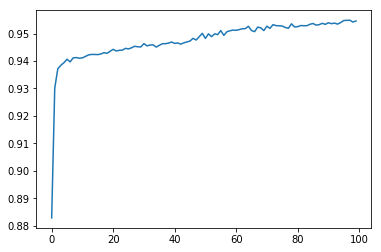

In [15]:
plt.plot(report2.history['acc'])

In [16]:
pred= model2.predict( x_test_processed )


In [17]:
len(pred[0]),len( y_test_processed[0]),len(classes)

(26, 26, 26)

In [18]:
print_info(y_test_processed, pred, classes)

               Class  Accuracy     Recall  Precision   F Score 
------------------------------------------------------------------------
 acceleration-active     0.999      0.999     1.000     1.000 
acceleration-inactive     0.999      0.999     1.000     1.000 
activity-hubDisconnected     1.000      1.000     1.000     1.000 
    activity-offline     1.000      1.000     1.000     1.000 
     activity-online     1.000      1.000     1.000     1.000 
         battery-XXX     1.000      1.000     1.000     1.000 
         button-held     0.999      0.999     1.000     1.000 
       button-pushed     0.996      0.996     1.000     0.998 
colorTemperature-XXX     0.993      0.993     1.000     0.996 
      contact-closed     0.997      0.997     1.000     0.998 
        contact-open     0.997      0.997     1.000     0.999 
           level-XXX     0.988      0.996     0.992     0.994 
         lock-locked     0.997      0.997     1.000     0.998 
       lock-unlocked     0.981      0.9

# Calcualte per class accuracy

In [19]:
# try:
#     print(X_test is None)
#     np.save( "x_test.npy", X_test )
#     np.save("y_test.npy", y_test)
#     np.save("y_pred.npy", pred )
#     np.save("classes.npy", classes)
# except:
#     X_test = np.load("x_test.npy")
#     y_test = np.load("y_test.npy")
#     pred   = np.load("y_pred.npy")
#     classes = np.load("classes.npy")

# Random Forest baseline calc

In [20]:
dim_size= 160
x_random_forest_train,y_random_forest_train, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
x_random_forest_test,y_random_forest_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False, classes=classes)
# x,y, classes = pre_process_raw( x_data, y_data , dim_size, zero_pad=True, normalize=True)

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=260, max_depth=200,
                             random_state=0 )
t_hist = clf.fit(x_random_forest_train, y_random_forest_train)

rf_pred= clf.predict(x_random_forest_test  )


# print(clf.feature_importances_)

# print(clf.predict([[0, 0, 0, 0]]))
# from sklearn import metrics
# scores = cross_val_score(clf, x_random_forest_train, y_random_forest_train, cv=10, scoring='accuracy')

In [22]:
print_info(y_random_forest_test, rf_pred, classes)

               Class  Accuracy     Recall  Precision   F Score 
------------------------------------------------------------------------
 acceleration-active     0.999      0.999     1.000     1.000 
acceleration-inactive     0.999      0.999     1.000     1.000 
activity-hubDisconnected     1.000      1.000     1.000     1.000 
    activity-offline     1.000      1.000     1.000     1.000 
     activity-online     1.000      1.000     1.000     1.000 
         battery-XXX     1.000      1.000     1.000     1.000 
         button-held     0.999      1.000     1.000     1.000 
       button-pushed     0.999      0.999     0.999     0.999 
colorTemperature-XXX     1.000      1.000     1.000     1.000 
      contact-closed     0.997      0.998     0.999     0.999 
        contact-open     0.998      0.998     1.000     0.999 
           level-XXX     0.997      0.998     0.999     0.998 
         lock-locked     0.999      0.999     1.000     1.000 
       lock-unlocked     0.999      0.9

In [23]:
# print_info(y_random_forest_test, rf_pred, classes)

In [24]:
# print ( "mean : %f \nstd: %f\nmax:%f" %( scores.mean(), scores.std(), scores.max()) )

# LSTM 

In [25]:
# create the model
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False,classes=classes)

In [26]:
word_count = np.max( x_lstm_prossed_train)+1 # len(np.unique( x ))

# create the model
embedding_vecor_length = 102
model = Sequential()
model.add(Embedding(word_count, embedding_vecor_length, input_length=dim_size))
model.add(Dropout(0.1))
model.add(LSTM(100))

model.add(Dense(127, activation='relu'))
model.add(Dense(len(classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
hist2 = model.fit(x_lstm_prossed_train, y_lstm_prossed_train, epochs=Epoch_count, batch_size=Batch_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 160, 102)          247044    
_________________________________________________________________
dropout_9 (Dropout)          (None, 160, 102)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               81200     
_________________________________________________________________
dense_3 (Dense)              (None, 127)               12827     
_________________________________________________________________
dense_4 (Dense)              (None, 26)                3328      
Total params: 344,399
Trainable params: 344,399
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
50358/50358 [==============================] - 29s - loss: 1.1702 - acc: 0.6835    
Epoch 2/100
50358/50358 [==========

In [27]:
# hist2 = model.fit(x_lstm_prossed_train, y_lstm_prossed_train, epochs=50, batch_size=500)

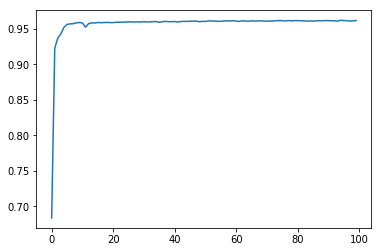

In [28]:
plt.plot(hist2.history['acc'])

In [29]:
model.save( "LSTM_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

In [30]:
lstm_pred = model.predict( x_lstm_prossed_test )

In [31]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

               Class  Accuracy     Recall  Precision   F Score 
------------------------------------------------------------------------
 acceleration-active     0.999      0.999     1.000     1.000 
acceleration-inactive     0.999      0.999     1.000     1.000 
activity-hubDisconnected     1.000      1.000     1.000     1.000 
    activity-offline     1.000      1.000     1.000     1.000 
     activity-online     1.000      1.000     1.000     1.000 
         battery-XXX     1.000      1.000     1.000     1.000 
         button-held     0.999      1.000     1.000     1.000 
       button-pushed     0.999      0.999     0.999     0.999 
colorTemperature-XXX     1.000      1.000     1.000     1.000 
      contact-closed     0.997      0.997     1.000     0.998 
        contact-open     0.997      0.998     1.000     0.999 
           level-XXX     0.996      0.996     0.999     0.998 
         lock-locked     0.997      0.997     1.000     0.998 
       lock-unlocked     0.999      0.9

In [32]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [33]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )
